# KSD Bandwidth sweep

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json_tricks as json
import copy

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Summary
Assume proposal $\mathcal N(0,1)$ and target $\mathcal N(1,1)$. Sample 400 particles from proposal.
Then KSD U-estimator has following bandwidth dependent dynamics:
* bandwidth $h<10^{-2}$: high variance, estimates from ~ -100 to 100. The true KSD is probably close to zero.
* bandwidth $10^{-2} < h < 10$: KSD grows from <0.1 to ca. 0.9. Variance still decently large.
* bandwidth $h>10$: KSD stays constant (kernel is essentially equal to $1$ everywhere)

#### The weirdest part:
KSD is *greatest* in the latter regime, where the bandwidth is totally indiscriminate. This is contrary to intuition---large KSD should mean a bandwidth that discriminates well.

Explanation: see markdown notes.

In [2]:
target   = distributions.Gaussian([0, 0], 1)
proposal = distributions.Gaussian([0, 0], 15)

In [3]:
samples = proposal.sample(400)
stein.ksd_squared_u(samples, target.logpdf, kernels.constant_kernel)

DeviceArray(-0.07143599, dtype=float32)

In [4]:
# def globally_maximal_stein_discrepancy(proposal, target):
def optimal_witness(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x)

def stein_op(x):
    f = optimal_witness
    return np.inner(grad(target.logpdf)(x), f(x)) + np.trace(jacfwd(f)(x))

def stein_op_true(x):
    return np.inner(optimal_witness(x), optimal_witness(x))

def stein_discrepancy(samples):
    return np.mean(vmap(stein_op_true)(samples))

In [5]:
optimal_stein_discrepancy = stein.stein_discrepancy(proposal.sample(1000), target.logpdf, optimal_witness)

In [6]:
stein_discrepancy(samples)

DeviceArray(26.194365, dtype=float32)

In [7]:
samples = proposal.sample(400)
steins = vmap(stein_op)(samples)
steins_check = vmap(stein_op_true)(samples)

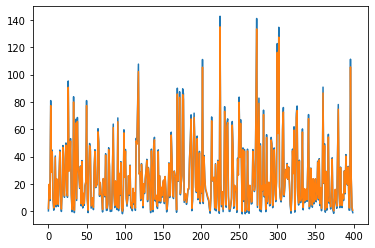

In [8]:
plt.plot(steins)
plt.plot(steins_check)

In [9]:
stein.globally_maximal_stein_discrepancy(proposal, target)

DeviceArray(27.058853, dtype=float32)

## sweep

In [10]:
m = 50 # nr of computations for var
n = 200 # nr particles

In [11]:
# estimate KSD and Var(\hat KSD) values for base kernels
def estimate_ksd_and_stddev(key, n: int, m: int, kernel, proposal, target, normalize_ksd=False):
    """
    n: number of particles
    m: number of draws for variance estimation
    
    Returns
    ksd: mean ksd value
    std: standard dev
    """
    ksds_list = []
    @jit
    def sample_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel, normalize=normalize_ksd, aux=False)
    for _ in range(m):
        key, subkey = random.split(key)
        samples = proposal.sample(n, key=subkey)
        ksd = sample_ksd(samples)
        ksds_list.append(ksd)
    ksd = np.mean(np.asarray(ksds_list))
    std = np.std(np.asarray(ksds_list))
    return ksd, std

In [12]:
key, subkey = random.split(key)
# @partial(jit, static_argnums=(1,2))
def compute_ksds(h, normalize_kernel=False, normalize_ksd=False):
    rbf = kernels.get_rbf_kernel(h, normalize_kernel)
    tophat = kernels.get_tophat_kernel(h, normalize_kernel)
    
    ksd_rbf, var_rbf = estimate_ksd_and_stddev(subkey, n, m, rbf, proposal, target, normalize_ksd)
    ksd_top, var_top = estimate_ksd_and_stddev(subkey, n, m, tophat, proposal, target, normalize_ksd)
    return ksd_rbf, var_rbf, ksd_top, var_top

In [13]:
def sweep_and_plot(grid, normalize_ksd=False, normalize_kernel=False):
    grid_means_rbf = []
    grid_means_top = []
    grid_var_rbf = []
    grid_var_top = []

    for h in tqdm(grid):
        ksd_rbf, var_rbf, ksd_top, var_top = compute_ksds(h, normalize_kernel, normalize_ksd)
        grid_means_rbf.append(ksd_rbf)
        grid_var_rbf.append(var_rbf)
        grid_means_top.append(ksd_top)
        grid_var_top.append(var_top)

    grid_var_rbf = np.array(grid_var_rbf)

    # estimate KSD and Var(\hat KSD) values for base kernels
    ksd_c, var_c = estimate_ksd_and_stddev(subkey, n, m, kernels.constant_kernel, proposal, target, normalize_ksd=normalize_ksd)
    return (grid_means_rbf, grid_var_rbf, grid_means_top, grid_var_top), (ksd_c, var_c)

    
def plotit(grid, grid_values, const_values, lims=(-5, 5)):
    (grid_means_rbf, grid_var_rbf, grid_means_top, grid_var_top) = grid_values
    (ksd_c, var_c) = const_values
    
    fig, ax = plt.subplots(figsize=[8,7])
    plt.errorbar(grid, grid_means_rbf, yerr=grid_var_rbf, fmt="--o", label="KSD-U")
    plt.errorbar(grid, grid_means_top, yerr=grid_var_top, fmt="--o", label="KSD-U-tophat")
    plt.axhline(y=ksd_c, label="constant kernel=1", color="r")
    plt.xscale("log")
    plt.ylabel("KSD")
    plt.xlabel("Bandwidth")
    plt.ylim(lims)
    plt.legend()

grid = 2**np.linspace(-13, 8, 50)

100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


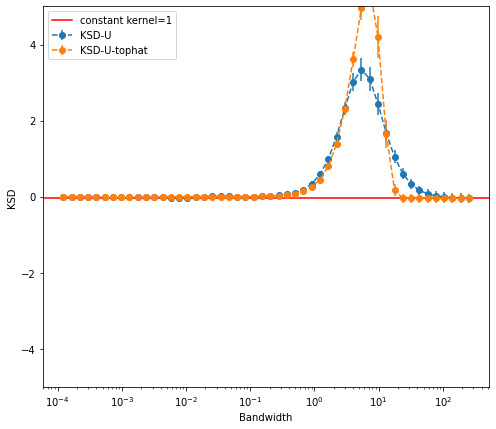

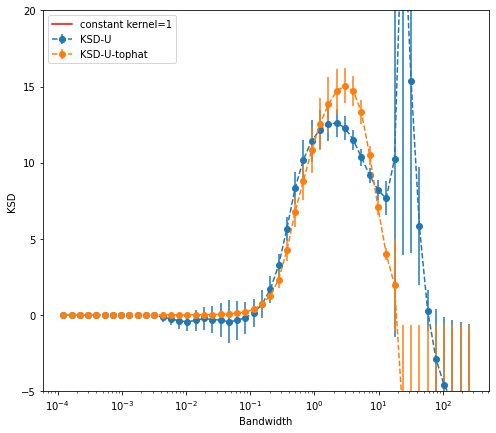

In [14]:
out = sweep_and_plot(grid, normalize_ksd=False, normalize_kernel=False)
plotit(grid, *out)
out = sweep_and_plot(grid, normalize_ksd=True, normalize_kernel=False)
plotit(grid, *out, lims=(-5, 20))

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


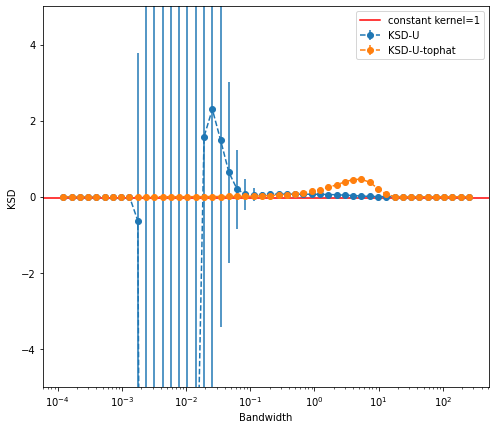

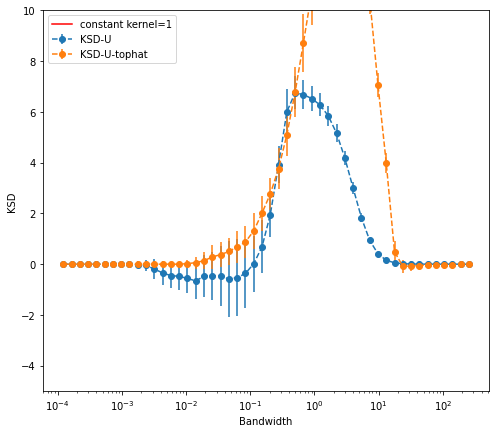

In [15]:
out = sweep_and_plot(grid, normalize_ksd=False, normalize_kernel=True)
plotit(grid, *out)
out = sweep_and_plot(grid, normalize_ksd=True, normalize_kernel=True)
plotit(grid, *out, lims=(-5, 10))

In [ ]:
sldkfjslk

### plot single sample

In [16]:
# @jit
def sample_ksd(sample, bandwidth):
    return stein.ksd_squared_u(sample, target.logpdf, kernels.get_rbf_kernel(bandwidth), False, False)
sample = proposal.sample(n)
grid_ksds_single = []
for h in grid:
    grid_ksds_single.append(sample_ksd(sample, h))
grid_ksds_single = np.array(grid_ksds_single)

NameError: name 'grid_var_rbf' is not defined

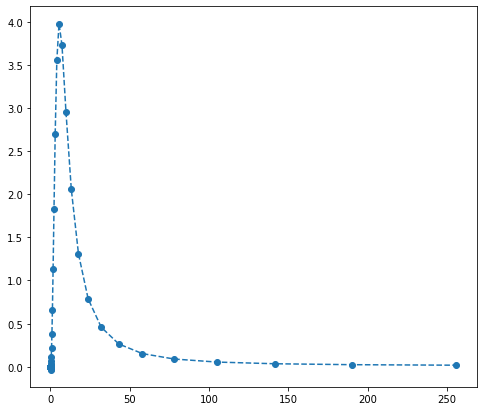

In [17]:
fig, ax = plt.subplots(figsize=[8,7])

plt.plot(grid, grid_ksds_single, "--o", label="KSD-U")
plt.plot(grid, grid_ksds_single / np.sqrt(grid_var_rbf), "--o", label="KSD-U variance regularized")
plt.ylim(lims)
plt.xscale("log")
plt.ylabel("KSD")
plt.xlabel("Bandwidth")
plt.legend()

## asymptote at $k(x, y) = 1$ is not scale-invariant

In [ ]:
slkdfj

In [ ]:
scales = np.linspace(1, 100, 100)
n = 400
ksds=[]
for scale in tqdm(scales):
    mean = scale*1
    stddev = scale*1
    proposal = distributions.Gaussian(0,stddev**2)
    target = distributions.Gaussian(mean, stddev**2)
    samples = proposal.sample(n)
    
    ksds.append(stein.ksd_squared_u(samples, target.logpdf, kernels.constant_kernel, False, False))

In [ ]:
plt.plot(scales, ksds, "r")
plt.yscale("log")